# **Molecular Data Machine Learning, low RMSE**

## POWERED BY LEONARDO COFONE

This project is part of a machine learning challenge focused on predicting the T80 lifetime of molecular devices based on their SMILES (Simplified Molecular-Input Line-Entry System) representation and additional chemical features. The goal is to develop a regression model capable of accurately forecasting how long these devices will last before their efficiency drops to 80% of the original value.

To achieve this, molecular structures were first converted into Morgan fingerprints, a widely-used method for encoding chemical information. These fingerprints, combined with other numerical and categorical features, were used as input for various regression models.

Several algorithms were explored

After thorough evaluation using cross-validation RMSE, the Random Forest Regressor was selected as the final model due to its strong predictive performance and robustness.

## **1) Analayze and fix the data**

In [1]:
!pip install rdkit-pypi
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import matplotlib.pyplot as plt

train_set = pd.read_csv('/kaggle/input/molecular-machine-learning/train.csv')
test_set = pd.read_csv('/kaggle/input/molecular-machine-learning/test.csv')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 34.1 MB/s eta 0:00:00


In [2]:
#Converting smiles columns to fingerprints
def smiles_to_morgan_fingerprint(smiles, radius=2, n_bits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        return list(fingerprint)
    else:
        return [0] * n_bits 

train_fps = [smiles_to_morgan_fingerprint(s) for s in train_set['Smiles']]
test_fps = [smiles_to_morgan_fingerprint(s) for s in test_set['Smiles']]

fps_columns = [f'fp_{i}' for i in range(len(train_fps[0]))]
train_fps_df = pd.DataFrame(train_fps, columns=fps_columns)
test_fps_df = pd.DataFrame(test_fps, columns=fps_columns)

train_set = pd.concat([train_set, train_fps_df], axis=1)
test_set = pd.concat([test_set, test_fps_df], axis=1)

train_set = train_set.drop(columns=['Smiles'], errors='ignore')
test_set = test_set.drop(columns=['Smiles'], errors='ignore')

X_train = train_set.drop(columns=['T80'])
y_train = train_set['T80']

missing_cols = set(X_train.columns) - set(test_set.columns)
for col in missing_cols:
    test_set[col] = 0

X_test = test_set[X_train.columns]

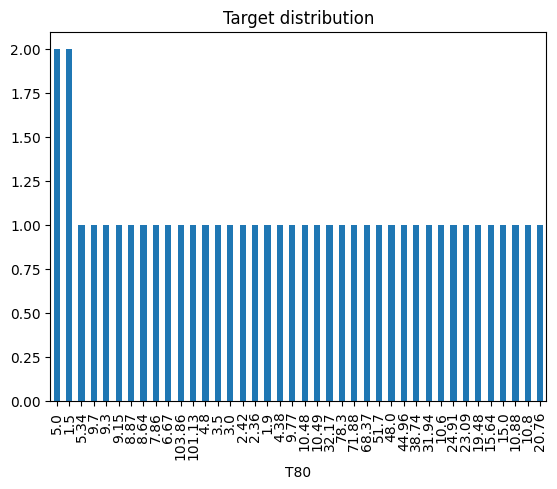

Categorical columns: Index(['Batch_ID'], dtype='object')


/tmp/ipykernel_13/803707635.py:24: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewed_feats = train_set[numeric_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)


Skew of numerical features:
fp_109     6.24695
fp_792     6.24695
fp_341     6.24695
fp_754     6.24695
fp_274     6.24695
            ...   
fp_1015        NaN
fp_1020        NaN
fp_1021        NaN
fp_1022        NaN
fp_1023        NaN
Length: 1168, dtype: float64
Feature with high skew: ['fp_109', 'fp_792', 'fp_341', 'fp_754', 'fp_274', 'fp_268', 'fp_374', 'fp_761', 'fp_769', 'fp_773', 'fp_170', 'fp_255', 'fp_385', 'fp_386', 'fp_173', 'fp_254', 'fp_340', 'fp_186', 'fp_406', 'fp_436', 'fp_821', 'fp_191', 'fp_671', 'fp_445', 'fp_457', 'fp_843', 'fp_473', 'fp_487', 'fp_203', 'fp_490', 'fp_752', 'fp_742', 'fp_504', 'fp_127', 'fp_110', 'fp_292', 'fp_100', 'fp_653', 'fp_87', 'fp_688', 'fp_77', 'fp_72', 'fp_68', 'fp_705', 'fp_63', 'fp_60', 'fp_59', 'fp_45', 'fp_334', 'fp_31', 'fp_25', 'fp_310', 'fp_311', 'fp_712', 'fp_284', 'fp_646', 'fp_3', 'fp_283', 'fp_645', 'fp_140', 'fp_727', 'fp_638', 'fp_499', 'fp_672', 'fp_117', 'fp_957', 'fp_922', 'fp_985', 'fp_517', 'fp_655', 'fp_901', 'fp_976', '

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [3]:
# View target distribution
train_set["T80"].value_counts().plot(kind='bar')
plt.title("Target distribution")
plt.show()


categorical_cols = train_set.select_dtypes(include='object').columns
print("Categorical columns:", categorical_cols)

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

train_set.hist(bins=50, figsize=(120, 100))
plt.show()

#search for heavy-tailed features

from scipy.stats import skew

numeric_cols = train_set.select_dtypes(include=np.number).columns
skewed_feats = train_set[numeric_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

print("Skew of numerical features:")
print(skewed_feats)

skewed_features = skewed_feats[skewed_feats > 0.8].index.tolist()
print("Feature with high skew:", skewed_features)

skewed_features = [col for col in skewed_features if col in X_train.columns]

## **2) Create a pipeline for a better preprocessing**

In [4]:
#PIPELINE
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer

log_transformer = make_pipeline(                      
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log1p, feature_names_out="one-to-one"),
    StandardScaler(),
)

numeric_transformer = make_pipeline(              
    SimpleImputer(strategy="median"),
    StandardScaler(),
)

categorical_transformer = make_pipeline(                       
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"),
)

preprocessor = ColumnTransformer([                       
    
    ("log", log_transformer, skewed_features),
    ("num", numeric_transformer, make_column_selector(dtype_include=np.number)),
    ("cat", categorical_transformer, categorical_cols),
])

## **3) Try different models with a creative function**

In [5]:
# WE CAN TRY WITH DIFFERENT MODELS
# Linear Regression
from sklearn.linear_model import LinearRegression
# Ridge Regression
from sklearn.linear_model import Ridge
# Lasso Regression
from sklearn.linear_model import Lasso
# ElasticNet Regression
from sklearn.linear_model import ElasticNet
# K-Nearest Neighbors Regressor
from sklearn.neighbors import KNeighborsRegressor
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
# Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor
# XGBoost Regressor
from xgboost import XGBRegressor
# HistGradientBoosting Regressor
from sklearn.ensemble import HistGradientBoostingRegressor
#metrics
from sklearn.model_selection import cross_val_score

models = ["LinearRegression", "Ridge", "Lasso", "ElasticNet", "KNeighborsRegressor", "RandomForestRegressor", "GradientBoostingRegressor", "HistGradientBoostingRegressor", "XGBRegressor"]

models_s = [
    LinearRegression(),
    Ridge(random_state=42),
    Lasso(random_state=42),
    ElasticNet(random_state=42),
    KNeighborsRegressor(),
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42),
    HistGradientBoostingRegressor(random_state=42),
    XGBRegressor(random_state=42),

]

saved_models = {}

for i, model_name in enumerate(models):
    cla = make_pipeline(preprocessor,models_s[i])
    mse_scores = cross_val_score(cla,  X_train, y_train, scoring="neg_mean_squared_error", cv=5)
    rmse_scores = np.sqrt(-mse_scores)
    saved_models[model_name] = models_s[i] 

    print(f"{model_name}: ")
    print(f"mean RMSE: {rmse_scores.mean()} (standard deviation: {rmse_scores.std()})\n")


LinearRegression: 
mean RMSE: 30.055085051381525 (standard deviation: 16.581850747401187)

Ridge: 
mean RMSE: 30.049217003291403 (standard deviation: 16.5745407038254)

Lasso: 
mean RMSE: 26.422527451744514 (standard deviation: 18.298874945217587)

ElasticNet: 
mean RMSE: 27.78532238807123 (standard deviation: 17.906639760266692)

KNeighborsRegressor: 
mean RMSE: 27.33434593171977 (standard deviation: 17.70303529017199)

RandomForestRegressor: 
mean RMSE: 24.494555706815795 (standard deviation: 18.13613666024128)

GradientBoostingRegressor: 
mean RMSE: 27.531937786927084 (standard deviation: 18.599623348168148)

HistGradientBoostingRegressor: 
mean RMSE: 25.86833068261002 (standard deviation: 18.389022773842317)

XGBRegressor: 
mean RMSE: 27.610292811935334 (standard deviation: 17.14215656356669)



In [6]:
from sklearn.pipeline import Pipeline

final_model = Pipeline([
    ("preprocessor1", preprocessor),
    ("RF", RandomForestRegressor(random_state=42)),
])
    
final_model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error
X_test_clean = X_test.select_dtypes(include=np.number)

X_test_clean = X_test_clean.replace([np.inf, -np.inf], np.nan)
X_test_clean = X_test_clean.fillna(X_test_clean.median())

X_test_non_numeric = X_test.select_dtypes(exclude=np.number)

X_test_non_numeric = X_test_non_numeric.apply(lambda x: x.fillna(x.mode()[0]) if not x.empty else x)

X_test_clean = pd.concat([X_test_clean, X_test_non_numeric], axis=1)

final_predictions = final_model.predict(X_test_clean)

print(final_predictions)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

rmse_scores = -cross_val_score(final_model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
print(f"mean RMSE from cross-validation: {rmse_scores.mean():.4f}, std: {rmse_scores.std():.4f}")

[71.462  36.8668 48.5311 35.6627 38.4253 59.8373 64.5346 24.7596 29.7761]
mean RMSE from cross-validation: 24.4946, std: 18.1361


## **4) Hyperparameters tuning**

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import numpy as np

rf = final_model

grom = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor())
])

param_dist = {
    'rf__n_estimators': randint(100, 1000),
    'rf__max_depth': randint(10, 50),
    'rf__min_samples_split': randint(2, 10),
    'rf__min_samples_leaf': randint(1, 10), 
    'rf__max_features': [1.0, 'sqrt', 'log2'], 
    'rf__bootstrap': [True, False],
}

random_search = RandomizedSearchCV(grom, param_distributions=param_dist, n_iter=100, cv=5, verbose=0, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

print(f"Best hyperparameters: {random_search.best_params_}")

best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)
rmse_scores = -cross_val_score(final_model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
print(f"mean RMSE from cross-validation: {rmse_scores.mean():.4f}, std: {rmse_scores.std():.4f}")


Best hyperparameters: {'rf__bootstrap': True, 'rf__max_depth': 42, 'rf__max_features': 1.0, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 8, 'rf__n_estimators': 295}
mean RMSE from cross-validation: 24.4946, std: 18.1361


## **5) Train the final model on the best hyperparameters**

In [8]:

model_fin = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestRegressor(n_estimators=295, max_depth=42, random_state=42, min_samples_split=8, min_samples_leaf=5, max_features=1.0, bootstrap=True))
])

model_fin.fit(X_train, y_train)

y_train_pred = model_fin.predict(X_train)

print(y_train_pred)

rmse_scores = -cross_val_score(final_model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
print(f"mean RMSE from cross-validation: {rmse_scores.mean():.4f}, std: {rmse_scores.std():.4f}")


[62.15514441 63.00092391 59.74803031 36.4468126  50.86913    26.73153476
 57.17970373 55.86709858 28.73833055 26.21637251 38.06641299 29.35303147
 15.23336302 19.77075927 15.65908695 12.84699305 10.53490845 24.09903891
 10.54362326 11.76564618 14.06888568  9.97265112 12.20536438  8.12054904
 10.50267797 13.32558983 16.66851428 16.38142368 30.6310501   6.68746138
  9.46903378 14.72260901  6.89050997  6.59159178  6.01793867  8.2146294
 23.85486152  6.28677135  6.49122574  5.835726   37.65846127 30.40715328]
mean RMSE from cross-validation: 24.4946, std: 18.1361


In [9]:
y_pred_da_consegnare = model_fin.predict(X_test)
print(y_pred_da_consegnare)

rmse_scores = -cross_val_score(model_fin, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
print(f"mean RMSE from cross-validation: {rmse_scores.mean():.4f}, std: {rmse_scores.std():.4f}")

[58.57433859 38.19537021 41.43296418 32.02090411 35.97488417 57.07723718
 61.41459748 37.65846127 30.40715328]
mean RMSE from cross-validation: 24.2119, std: 18.8971


In [10]:
submission = pd.DataFrame({
    'Id': test_set['Batch_ID'],
    'T80': y_pred_da_consegnare
})

submission.to_csv('submission.csv', index=False)


## **Thank you all!!**